## 目的：前行程のテスト結果からバグ数、障害件数を予測し、相関の強い項目を特定する

PMOからもらったデータから使用項目に絞って分析する

各項目について

項目名　| 意味 
-----------| ------------  
wbs | wbsコード 
bug_u | 単体テストバグ数 
bug_c | 結合テストバグ数  
bug_s | システムテストバグ数
issue | 本番化後障害件数 
check_o | 外設レビュー指摘数  
check_i | 内設レビュー指摘数  
check_cd | コードレビュー指摘数  
check_u | 単体テストレビュー指摘数  
check_c | 結合テストレビュー指摘数  
check_s | システムテストレビュー指摘数 
cost_i | 直営工数 
cost_e | 外注工数 
term | 工期（月数） 
test_u | 単体テスト項目数 
test_c | 結合テスト項目数 
test_s | システムテスト項目数 


## インプットデータの読み込みと整形

In [64]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.ensemble import RandomForestRegressor

In [53]:
#各種データセットを読み込み
df_bug = pd.read_csv("./input/bug.csv")
df_comp = pd.read_csv("./input/comp.csv")
df_review = pd.read_csv("./input/review.csv")
df_term = pd.read_csv("./input/term.csv")
df_test = pd.read_csv("./input/test.csv")

#df_bug.join(df_comp,how='inner')
df_train = pd.merge(df_bug,df_comp,how='inner',on='wbs')
df_train = pd.merge(df_train,df_review,how='inner',on='wbs')
df_train = pd.merge(df_train,df_term,how='inner',on='wbs')
df_train = pd.merge(df_train,df_test,how='inner',on='wbs')
display(df_train.head())
df_train.info()

,wbs,bug_u,bug_c,bug_s,issue,check_o,check_i,check_cd,check_u,check_c,check_s,cost_i,cost_e,term,test_u,test_c,test_s
0,11AC2116170,0,0.0,0.0,NaN,NaN,7.0,0.0,0.0,NaN,0.0,1.6,0.0,3,25,105.0,7.0
1,11AC2117003,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,4.9,4.9,7,530,463.0,102.0
2,11FC117BS40,15,4.0,3.0,0.0,57.0,67.0,2.0,15.0,4.0,2.0,1.2,6.5,3,778,41.0,124.0
3,11AC2117018,55,13.0,0.0,13.0,81.0,91.0,24.0,NaN,NaN,NaN,10.2,22.6,5,776,260.0,17.0
4,11AC2117008,28,4.0,0.0,0.0,36.0,36.0,NaN,NaN,NaN,NaN,4.4,7.9,3,789,182.0,81.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 17 columns):
wbs         129 non-null object
bug_u       129 non-null int64
bug_c       97 non-null float64
bug_s       128 non-null float64
issue       120 non-null float64
check_o     114 non-null float64
check_i     127 non-null float64
check_cd    9 non-null float64
check_u     34 non-null float64
check_c     21 non-null float64
check_s     45 non-null float64
cost_i      129 non-null float64
cost_e      129 non-null float64
term        129 non-null int64
test_u      129 non-null int64
test_c      99 non-null float64
test_s      128 non-null float64
dtypes: float64(13), int64(3), object(1)
memory usage: 18.1+ KB


In [59]:
#異常値を除外（システムテスト項目数が単体テスト、結合テストに比べて多すぎる、カウント方法が違っているためと予想）
#異常値と思われる行はwbsを指定
df_train = df_train[~df_train['wbs'].isin(['11AC2117050'])]

#本番化後の障害件数が多いプロジェクトがあるが、そのままにしておく
#df_train = df_train[~df_train['wbs'].isin(['11FC117BS70'])]

#欠損値を埋める(0 or 平均 or 中央値)
df_train['bug_c'].fillna(0, inplace=True)
df_train['bug_s'].fillna(0, inplace=True)
df_train['issue'].fillna(0, inplace=True)
df_train['check_o'].fillna(0, inplace=True)
#レビュー指摘数の内部設計書レビュー指摘数は平均値で埋める
df_train['check_i'].fillna(df_train['check_i'].mean(), inplace=True)
df_train['check_cd'].fillna(0, inplace=True)
df_train['check_u'].fillna(0, inplace=True)
df_train['check_c'].fillna(0, inplace=True)
df_train['check_s'].fillna(0, inplace=True)
df_train['test_c'].fillna(0, inplace=True)
df_train['test_s'].fillna(0, inplace=True)


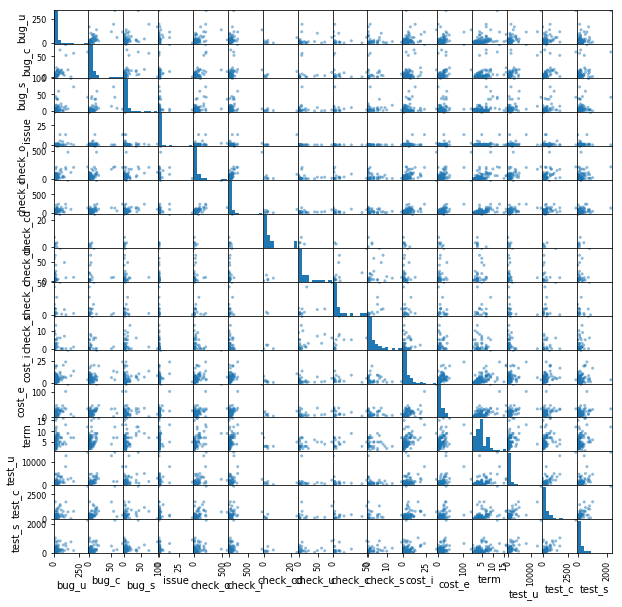

In [44]:
#データの相関を確認
pd.plotting.scatter_matrix(df_train, figsize=(10,10))
plt.show()

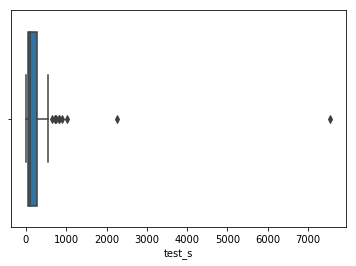

In [55]:
# 箱ひげ図を書いてみる 
sns.boxplot(df_train.test_s)
plt.show()

In [60]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 128
Data columns (total 17 columns):
wbs         128 non-null object
bug_u       128 non-null int64
bug_c       128 non-null float64
bug_s       128 non-null float64
issue       128 non-null float64
check_o     128 non-null float64
check_i     128 non-null float64
check_cd    128 non-null float64
check_u     128 non-null float64
check_c     128 non-null float64
check_s     128 non-null float64
cost_i      128 non-null float64
cost_e      128 non-null float64
term        128 non-null int64
test_u      128 non-null int64
test_c      128 non-null float64
test_s      128 non-null float64
dtypes: float64(13), int64(3), object(1)
memory usage: 18.0+ KB


## モデルの作成

モデルの作成について
ランダムフォレストを使用してモデルを作成する
そのため値の標準化はしない
単体テストバグ数、結合テストバグ数、システムテストバグ数＋本番化後障害件数の３つに分けて学習させる

### １．単体テストバグ数
目的変数：単体テストバグ数(bug_u)

説明変数：外設レビュー指摘数(check_o)、内設レビュー指摘数(check_i)、コードレビュー指摘数(check_cd)、単体テストレビュー指摘数(check_u)、
直営工数(cost_i)、外注工数(cost_e)、工期（月数）(term)、単体テスト項目数(test_u)


,check_o,check_i,check_cd,check_u,cost_i,cost_e,term,test_u
0,0.0,7.0,0.0,0.0,1.6,0.0,3,25
1,0.0,0.0,0.0,0.0,4.9,4.9,7,530
2,57.0,67.0,2.0,15.0,1.2,6.5,3,778
3,81.0,91.0,24.0,0.0,10.2,22.6,5,776
4,36.0,36.0,0.0,0.0,4.4,7.9,3,789


[4.37599255e-01 3.26116896e-02 0.00000000e+00 1.65407695e-05
 7.48764578e-03 2.19970740e-01 1.16812717e-02 2.90632857e-01]


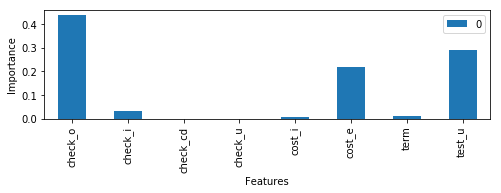

In [87]:
explain_col = ["check_o","check_i","check_cd","check_u","cost_i","cost_e","term","test_u"] 
target = ["bug_u"]
X = df_train[explain_col]
display(X.head())
y = df_train[target].values.reshape(-1)
rfr = RandomForestRegressor(max_depth=None, min_samples_leaf=4, random_state=42)
rfr.fit(X, y)
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(rfr.feature_importances_)
pd.DataFrame(rfr.feature_importances_, index=explain_col).plot.bar(figsize=(8,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### ２．結合テストバグ数
目的変数：結合テストバグ数(bug_c)

説明変数：外設レビュー指摘数(check_o)、内設レビュー指摘数(check_i)、コードレビュー指摘数(check_cd)、単体テストレビュー指摘数(check_u)、
直営工数(cost_i)、外注工数(cost_e)、工期（月数）(term)、単体テスト項目数(test_u)、単体テストバグ数(bug_u)、結合テストレビュー指摘数(check_c)、結合テスト項目数(test_c)


,check_o,check_i,check_cd,check_u,cost_i,cost_e,term,test_u,bug_u,check_c,test_c
0,0.0,7.0,0.0,0.0,1.6,0.0,3,25,0,0.0,105.0
1,0.0,0.0,0.0,0.0,4.9,4.9,7,530,0,0.0,463.0
2,57.0,67.0,2.0,15.0,1.2,6.5,3,778,15,4.0,41.0
3,81.0,91.0,24.0,0.0,10.2,22.6,5,776,55,0.0,260.0
4,36.0,36.0,0.0,0.0,4.4,7.9,3,789,28,0.0,182.0


[0.16524311 0.00046052 0.         0.         0.11511637 0.09260616
 0.03249577 0.17694426 0.3093442  0.00040981 0.10737981]


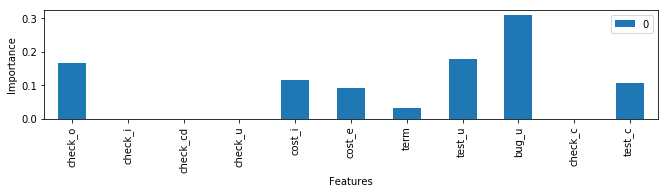

In [88]:
explain_col = ["check_o","check_i","check_cd","check_u","cost_i","cost_e","term","test_u","bug_u","check_c","test_c"] 
target = ["bug_c"]
X = df_train[explain_col]
display(X.head())
y = df_train[target].values.reshape(-1)
rfr = RandomForestRegressor(max_depth=None, min_samples_leaf=4, random_state=42)
rfr.fit(X, y)
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(rfr.feature_importances_)
pd.DataFrame(rfr.feature_importances_, index=explain_col).plot.bar(figsize=(11,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### ３．システムテストバグ数＋本番化後障害件数
目的変数：システムテストバグ数(bug_s)＋本番化後障害件数(issue)

説明変数：外設レビュー指摘数(check_o)、内設レビュー指摘数(check_i)、コードレビュー指摘数(check_cd)、単体テストレビュー指摘数(check_u)、
直営工数(cost_i)、外注工数(cost_e)、工期（月数）(term)、単体テスト項目数(test_u)、単体テストバグ数(bug_u)、結合テストレビュー指摘数(check_c)、結合テスト項目数(test_c)、結合テストバグ数(bug_c)、システムテストレビュー指摘数(check_s)、システムテスト項目数(test_s)


,check_o,check_i,check_cd,check_u,cost_i,cost_e,term,test_u,bug_u,check_c,test_c,bug_c,check_s,test_s
0,0.0,7.0,0.0,0.0,1.6,0.0,3,25,0,0.0,105.0,0.0,0.0,7.0
1,0.0,0.0,0.0,0.0,4.9,4.9,7,530,0,0.0,463.0,0.0,0.0,102.0
2,57.0,67.0,2.0,15.0,1.2,6.5,3,778,15,4.0,41.0,4.0,2.0,124.0
3,81.0,91.0,24.0,0.0,10.2,22.6,5,776,55,0.0,260.0,13.0,0.0,17.0
4,36.0,36.0,0.0,0.0,4.4,7.9,3,789,28,0.0,182.0,4.0,0.0,81.0


[9.25608130e-02 8.15969353e-02 0.00000000e+00 7.52900739e-05
 3.24951118e-03 7.26347382e-03 2.45456938e-02 3.86116097e-02
 3.56514717e-01 0.00000000e+00 1.20630620e-02 2.42981993e-01
 3.17339181e-03 1.37363509e-01]


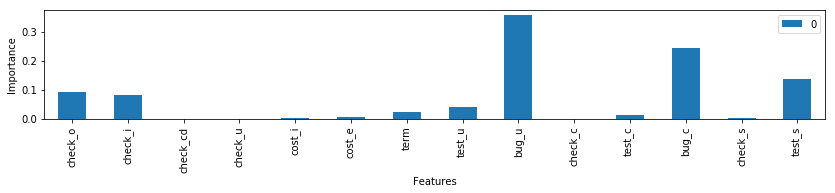

In [89]:
explain_col = ["check_o","check_i","check_cd","check_u","cost_i","cost_e","term","test_u",
               "bug_u","check_c","test_c","bug_c","check_s","test_s"] 
target = ["bug_c"]
X = df_train[explain_col]
display(X.head())
y = df_train["bug_s"].values + df_train["issue"].values
rfr = RandomForestRegressor(max_depth=None, min_samples_leaf=4, random_state=42)
rfr.fit(X, y)
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(rfr.feature_importances_)
pd.DataFrame(rfr.feature_importances_, index=explain_col).plot.bar(figsize=(14,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()